In [1]:
!pip install "seqeval" evaluate

  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'seqeval' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'seqeval'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16250 sha256=5272f30f1720b2ba68eacb64d21eb179b026f1021e39f00e83670b52319fef42
  Stored in directory: /home/zeus/.cache/pip/wheels/5f/b8/73/0b2c1a76b701a677653dd79ece07cfabd7457989dbfbdcd8d7
Successfully built seqeval
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [evaluate]


In [1]:
import gc
import torch
import numpy as np
import evaluate
from datasets import load_dataset

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    pipeline
)


In [2]:
from datasets import load_dataset

# Prepare data and splits
tomatoes = load_dataset("rotten_tomatoes")
train_data, test_data = tomatoes["train"], tomatoes["test"]

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load Model and Tokenizer
model_id = "bert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
from transformers import DataCollatorWithPadding

# Pad to the longest sequence in the batch
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def preprocess_function(examples):
   """Tokenize input data"""
   return tokenizer(examples["text"], truncation=True)

# Tokenize train/test data
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_test = test_data.map(preprocess_function, batched=True)

In [5]:
import numpy as np
import evaluate


def compute_metrics(eval_pred):
    """Calculate F1 score"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    load_f1 = evaluate.load("f1")
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"f1": f1}

In [14]:
from transformers import TrainingArguments, Trainer
import numpy as np
import evaluate
import torch

# Training arguments
training_args = TrainingArguments(
   "model",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=1,
   weight_decay=0.01,
   save_strategy="epoch",
   report_to="none",
   fp16=torch.cuda.is_available()
)

# CORRECT compute_metrics function
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):     # correct name
   logits, labels = eval_pred       # FIXED
   predictions = np.argmax(logits, axis=1)
   f1 = f1_metric.compute(predictions=predictions, references=labels)["f1"]
   return {"f1": f1}



In [15]:
# Trainer which executes the training process
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [11]:
trainer.train()

Step,Training Loss
500,0.421000


TrainOutput(global_step=534, training_loss=0.41564099886890654, metrics={'train_runtime': 63.2382, 'train_samples_per_second': 134.887, 'train_steps_per_second': 8.444, 'total_flos': 227605451772240.0, 'train_loss': 0.41564099886890654, 'epoch': 1.0})

In [16]:
results = trainer.evaluate()
print(results)



{'eval_loss': 0.3582523465156555, 'eval_f1': 0.8544600938967136, 'eval_runtime': 1.1394, 'eval_samples_per_second': 935.55, 'eval_steps_per_second': 58.801}


In [17]:
from transformers import pipeline
import torch

# Move to CPU if no GPU
device = 0 if torch.cuda.is_available() else -1

# Create a text classification pipeline using your fine-tuned model
classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=device
)

# Test examples
test_reviews = [
    "I absolutely loved this movie! The acting was superb and the plot was engaging.",
    "This was a complete waste of time. Boring and predictable.",
    "It was okay, not the best but certainly not the worst."
]

# Print label mapping
print(f"Labels: {model.config.id2label}")  
# Example: {0: "NEGATIVE", 1: "POSITIVE"}

# Run inference on each review
for review in test_reviews:
    result = classifier(review)[0]  # pipeline returns a list
    label = result["label"]
    score = result["score"]

    print("\nReview:", review)
    print("Predicted Label:", label)
    print("Confidence Score:", round(score, 4))


Labels: {0: 'LABEL_0', 1: 'LABEL_1'}

Review: I absolutely loved this movie! The acting was superb and the plot was engaging.
Predicted Label: LABEL_1
Confidence Score: 0.9816

Review: This was a complete waste of time. Boring and predictable.
Predicted Label: LABEL_0
Confidence Score: 0.9505

Review: It was okay, not the best but certainly not the worst.
Predicted Label: LABEL_0
Confidence Score: 0.6891


In [18]:
!pip install scikit-learn matplotlib


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [19]:
import numpy as np

predictions_output = trainer.predict(tokenized_test)
logits = predictions_output.predictions
labels = predictions_output.label_ids

y_pred = np.argmax(logits, axis=1)
y_true = labels


In [21]:
!pip install seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
cm


array([[456,  77],
       [ 78, 455]])

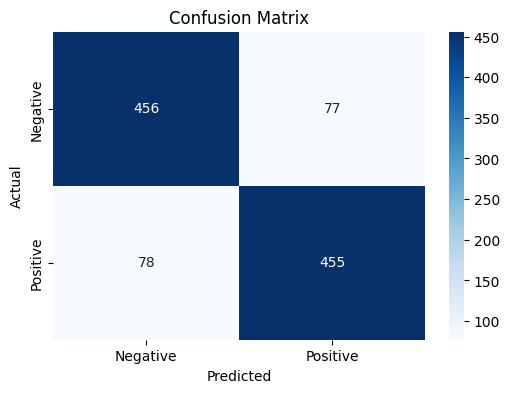

In [23]:
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))


              precision    recall  f1-score   support

    Negative       0.85      0.86      0.85       533
    Positive       0.86      0.85      0.85       533

    accuracy                           0.85      1066
   macro avg       0.85      0.85      0.85      1066
weighted avg       0.85      0.85      0.85      1066

